In [1]:
import numpy as np
import pandas as pd
import re
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.rk import RK45
import matplotlib.pyplot as plt


### Dummy Coupled ODE System

Let the state vector be $\mathbf{H}(t) = [H_0, H_1, H_2, H_3, H_4]$. The system is defined as:

$$
\begin{aligned}
\frac{dH_0}{dt} &= X_0 - Y_0 \\
\frac{dH_1}{dt} &= X_1 + Y_0(H_0) - X_2(H_1) - Y_1 - I_2 \\
\frac{dH_2}{dt} &= X_2(H_1) - Y_2 \\
\frac{dH_3}{dt} &= I_2(H_1) - I_3(H_3) - Y_3 \\
\frac{dH_4}{dt} &= I_3(H_3) - Y_4
\end{aligned}
$$

---

### Dummy Inputs Used

The inputs are modeled as simple functions or constants:

* $X_0 = 1.0$
* $Y_0 = 0.5 \cdot H_0$
* $X_1 = 1.2$
* $X_2 = 0.3 \cdot H_1$
* $I_2 = 0.6$
* $I_3 = 0.4 \cdot H_3$
* $Y_1 = 0.4$
* $Y_2 = 0.2$
* $Y_3 = 0.3$
* $Y_4 = 0.1$



In [2]:
# Define the ODE right-hand side function
def rhs(t, y):
    H0, H1, H2, H3, H4 = y

    # Dummy inputs/constants
    X0 = 1.0
    Y0 = 0.5 * H0

    X1 = 1.2
    X2 = 0.3 * H1
    Y1 = 0.4
    Y2 = 0.2
    Y3 = 0.3
    Y4 = 0.1

    I2 = 0.6 * H1
    I3 = 0.4 * H3

    dH0 = X0 - Y0
    dH1 = X1 + Y0 - X2 - Y1 - I2
    dH2 = X2 - Y2
    dH3 = I2 - I3 - Y3
    dH4 = I3 - Y4

    return [dH0, dH1, dH2, dH3, dH4]

# Set time span and evaluation grid
t_span = (0.0, 5.0)
t_eval = np.linspace(*t_span, 500)
t_fine = np.linspace(*t_span, 1000)

# Initial conditions for the first solves
initial_conditions = [1.0, 1.0, 1.0, 1.0, 1.0]

In [3]:
# Function to plot multiple H‐variables over time
def plot_time_series(sol, labels, title):
    plt.figure(figsize=(10, 6))
    for i, lbl in enumerate(labels):
        plt.plot(sol.t, sol.y[i], label=lbl)
    plt.xlabel('Time')
    plt.ylabel('State Variables')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

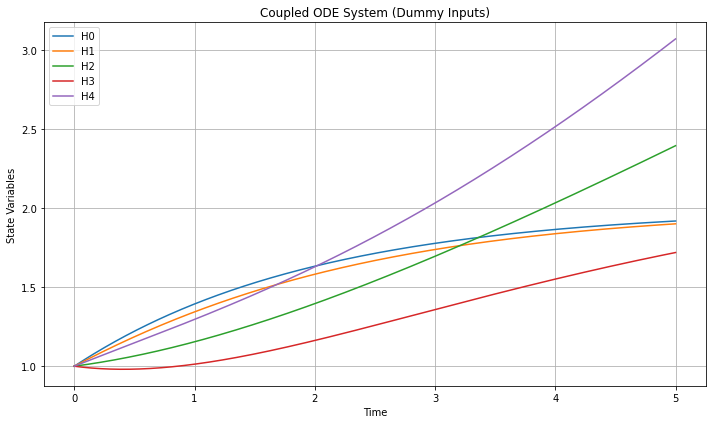

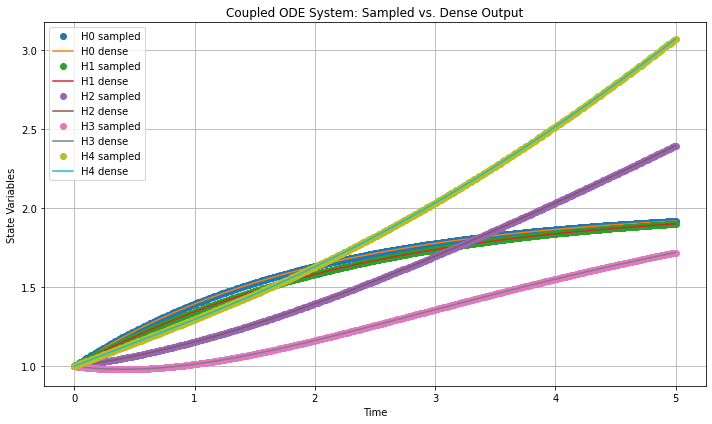

In [4]:
# Solve the ODE once and plot
sol_initial = solve_ivp(
    rhs,
    t_span,
    initial_conditions,
    method='RK45',
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-9
)
labels = [f"H{i}" for i in range(5)]
plot_time_series(sol_initial, labels, "Coupled ODE System (Dummy Inputs)")

# Solve again with dense output and compare sampled vs. dense
sol_dense = solve_ivp(
    rhs,
    t_span,
    initial_conditions,
    method='RK45',
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-9,
    dense_output=True
)
y_dense = sol_dense.sol(np.linspace(*t_span, 2000))

plt.figure(figsize=(10, 6))
for i, lbl in enumerate(labels):
    plt.plot(sol_dense.t, sol_dense.y[i], 'o', label=f"{lbl} sampled")
    plt.plot(np.linspace(*t_span, 2000), y_dense[i], '-', label=f"{lbl} dense")
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Coupled ODE System: Sampled vs. Dense Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

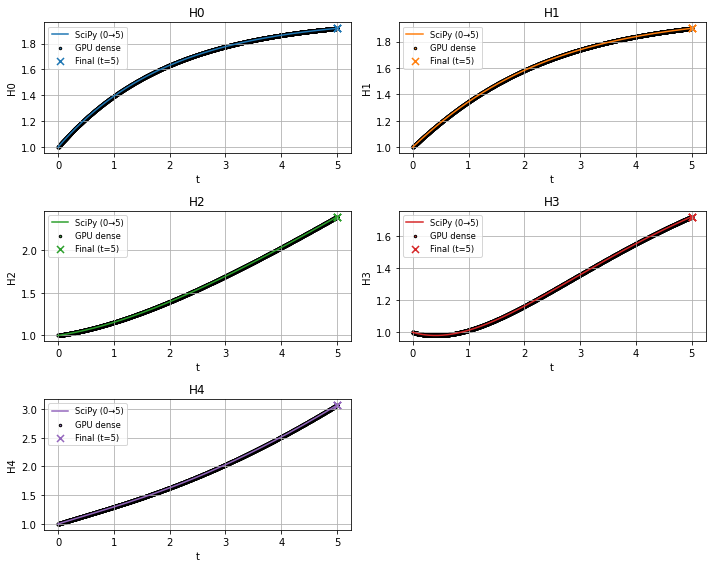

In [5]:
# Load GPU‐dense output from CSV
dense_df = pd.read_csv("dense.csv")
col_prefix = "Var"  # columns named Var0_sys0, Var1_sys0, …, Var4_sys0
times_gpu = dense_df["time"].values

# Build H_gpu_tau0 for system 0
H_gpu_tau0 = np.vstack([
    dense_df[f"{col_prefix}{i}_sys0"].values
    for i in range(5)
]).T  # shape = (N_rows, 5)

# Solve the ODE with SciPy on [0,5], using the GPU initial state for system 0
y0 = H_gpu_tau0[0]
sol = solve_ivp(
    rhs,
    t_span,
    y0,
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
    dense_output=True
)
Y_fine = sol.sol(t_fine).T  # shape = (1000, 5)

# Load final.csv and build H_final
final_df = pd.read_csv("final.csv")
H_final = np.vstack([
    final_df[f"{col_prefix}{i}"].values
    for i in range(5)
]).T  # shape = (n_rows, 5)
n_rows = H_final.shape[0]
times_final = np.full(n_rows, t_span[1])  

# Plot SciPy curve, GPU dense markers, and final values at t=5 for system 0
plt.figure(figsize=(10, 8))
for i in range(5):
    ax = plt.subplot(3, 2, i + 1)
    ax.plot(
        t_fine,
        Y_fine[:, i],
        "-",
        label="SciPy (0→5)",
        color=f"C{i}"
    )
    ax.scatter(
        times_gpu,
        H_gpu_tau0[:, i],
        s=6,
        label="GPU dense",
        color=f"C{i}",
        edgecolor="k"
    )
    ax.scatter(
        times_final,
        H_final[:, i],
        s=50,
        marker="x",
        label="Final (t=5)",
        color=f"C{i}"
    )
    ax.set_title(f"H{i}")
    ax.set_xlabel("t")
    ax.set_ylabel(f"H{i}")
    ax.legend(fontsize="small")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Solve from GPU‐initial state and compare to SciPy final
y0_gpu = H_gpu_tau0[0]
sol_gpu_init = solve_ivp(
    rhs,
    t_span,
    y0_gpu,
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
    dense_output=True
)
H_scipy_final = sol_gpu_init.sol(t_span[1])
H_gpu_final = H_final[0]

print("SciPy final at t=5:     ", H_scipy_final)
print("GPU final  from CSV:    ", H_gpu_final)

abs_err = np.abs(H_gpu_final - H_scipy_final)
rel_err = abs_err / (np.abs(H_scipy_final) + 1e-16)

print("\nAbsolute errors:")
for i in range(5):
    print(f" H{i}: {abs_err[i]:.2e}")

print("\nRelative errors:")
for i in range(5):
    print(f" H{i}: {rel_err[i]:.2e}")

SciPy final at t=5:      [1.91793531 1.90019549 2.3941564  1.71879841 3.06951438]
GPU final  from CSV:     [1.91791 1.90017 2.39397 1.71872 3.06922]

Absolute errors:
 H0: 2.53e-05
 H1: 2.55e-05
 H2: 1.86e-04
 H3: 7.84e-05
 H4: 2.94e-04

Relative errors:
 H0: 1.32e-05
 H1: 1.34e-05
 H2: 7.79e-05
 H3: 4.56e-05
 H4: 9.59e-05



Steps taken by SciPy RK45: 12
Detected 4 system(s), 5 variable(s)


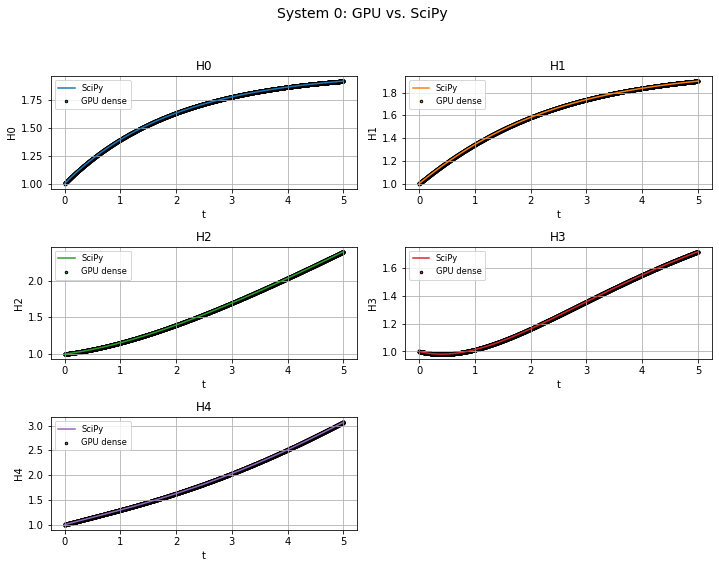

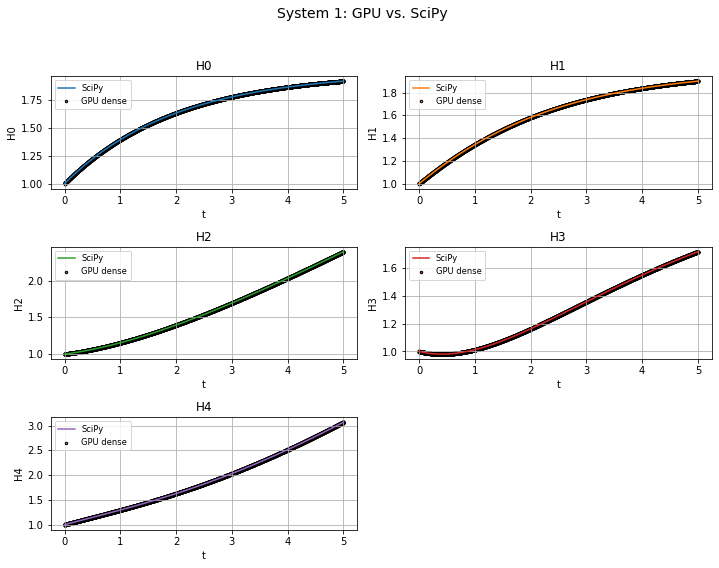

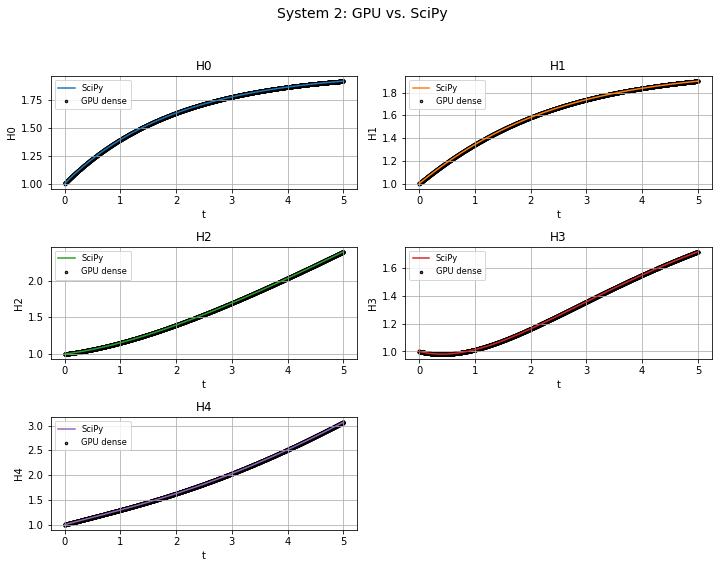

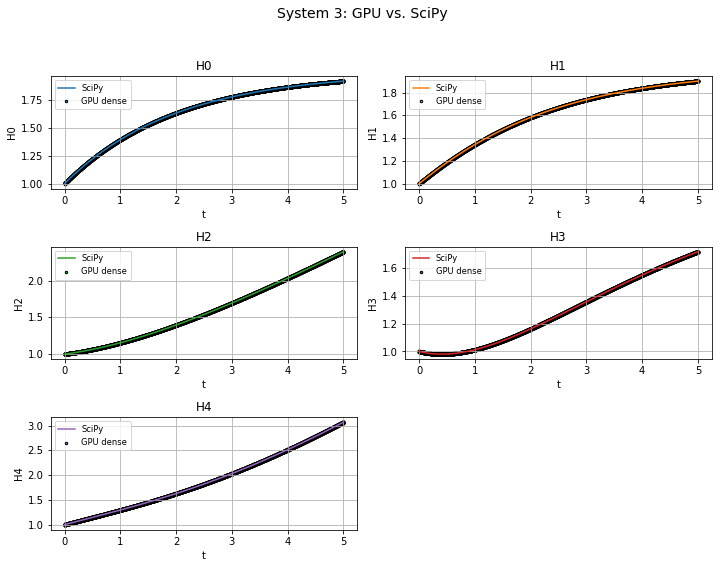

In [7]:
# Detailed GPU vs. SciPy for each system
n_scipy_steps = len(sol_gpu_init.t)
print(f"\nSteps taken by SciPy RK45: {n_scipy_steps}")

col_regex = re.compile(r"([A-Za-z]+)(\d+)_sys(\d+)")
systems = {}
for col in dense_df.columns:
    m = col_regex.fullmatch(col)
    if not m:
        continue
    var_idx = int(m.group(2))
    sys_idx = int(m.group(3))
    systems.setdefault(sys_idx, {})[var_idx] = col

num_systems = len(systems)
num_vars = max(len(v) for v in systems.values())
print(f"Detected {num_systems} system(s), {num_vars} variable(s)")

t_fine = np.linspace(*t_span, 1000)
for s_idx, col_map in systems.items():
    H_gpu_s = np.vstack([dense_df[col_map[i]].values for i in range(num_vars)]).T
    y0_s = H_gpu_s[0]

    sol_s = solve_ivp(
        rhs,
        t_span,
        y0_s,
        method="RK45",
        rtol=1e-6,
        atol=1e-9,
        dense_output=True
    )
    Y_fine_s = sol_s.sol(t_fine).T

    plt.figure(figsize=(10, 8))
    plt.suptitle(f"System {s_idx}: GPU vs. SciPy", fontsize=14)
    for i in range(num_vars):
        ax = plt.subplot(3, 2, i + 1)
        ax.plot(t_fine, Y_fine_s[:, i], "-", label="SciPy", color=f"C{i}")
        ax.scatter(times_gpu, H_gpu_s[:, i], s=6,
                   label="GPU dense", color=f"C{i}", edgecolor="k")
        ax.set_title(f"H{i}")
        ax.set_xlabel("t")
        ax.set_ylabel(f"H{i}")
        ax.legend(fontsize="small")
        ax.grid(True)

    if num_vars < 6:
        plt.subplot(3, 2, 6).axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


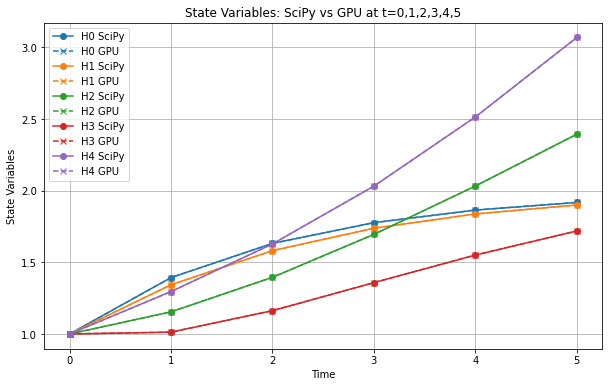

SciPy’s initial step h0 = 0.03150529000008159


In [8]:
# Times at which to compare SciPy vs. GPU
times_to_compare = np.array([0, 1, 2, 3, 4, 5])

# Solve with SciPy at those exact times
y0 = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
sol_cmp = solve_ivp(
    rhs,
    (0, 5),
    y0,
    t_eval=times_to_compare,
    method='RK45',
    rtol=1e-6,
    atol=1e-9
)

# Build a DataFrame of SciPy results
scipy_results = pd.DataFrame(sol_cmp.y.T, columns=[f'H{i}' for i in range(5)])
scipy_results['time'] = times_to_compare

# Prepare GPU results at those same times
gpu_data = []
nearest_times = []
system_index = 0  # compare system 0

for t in times_to_compare:
    if t == 0:
        gpu_row = [1.0] * 5
        nt = 0.0
    elif t == 5:
        gpu_row = final_df.loc[0, [f'{col_prefix}{i}' for i in range(5)]].values.tolist()
        nt = 5.0
    else:
        idx = (np.abs(dense_df['time'] - t)).idxmin()
        row = dense_df.loc[idx]
        gpu_row = [row[f'{col_prefix}{i}_sys{system_index}'] for i in range(5)]
        nt = row['time']

    gpu_data.append(gpu_row)
    nearest_times.append(nt)

gpu_results = pd.DataFrame(gpu_data, columns=[f'H{i}_gpu' for i in range(5)])
gpu_results['time'] = times_to_compare
gpu_results['nearest_time'] = nearest_times

# Merge SciPy vs GPU into one table
comparison_df = scipy_results.merge(gpu_results, on='time')

# Compute absolute and relative errors
for i in range(5):
    comparison_df[f'abs_err_H{i}'] = np.abs(comparison_df[f'H{i}'] - comparison_df[f'H{i}_gpu'])
    comparison_df[f'rel_err_H{i}'] = comparison_df[f'abs_err_H{i}'] / np.abs(comparison_df[f'H{i}'])

# Save comparison table to CSV
comparison_df.set_index('time', inplace=True)
comparison_df.to_csv("comparison.csv")

# Plot SciPy vs GPU at t=0,1,2,3,4,5 
plt.figure(figsize=(10, 6))
for i in range(5):
    color = f"C{i}"
    plt.plot(
        scipy_results['time'],
        scipy_results[f'H{i}'],
        marker='o',
        color=color,
        label=f'H{i} SciPy'
    )
    plt.plot(
        gpu_results['time'],
        gpu_results[f'H{i}_gpu'],
        marker='x',
        linestyle='--',
        color=color,
        label=f'H{i} GPU'
    )

plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('State Variables: SciPy vs GPU at t=0,1,2,3,4,5')
plt.legend()
plt.grid(True)
plt.savefig('test.png')
plt.show()

# Get SciPy’s initial RK45 step size (h_abs)
solver = RK45(rhs, 0.0, y0, 5.0, rtol=1e-6, atol=1e-9)
h0 = solver.h_abs
print("SciPy’s initial step h0 =", h0)
